In [1]:
#준비
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
#3D data set 구성
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [3]:
#SVD분해를 이용한 PC(주성분)구하기
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0] #첫번째 주성분
c2 = Vt.T[:, 1] #두번째 주성분

In [4]:
#주성분 벡터와 훈련 data의 접곱을 통한 투영
m, n = X.shape

S = np.zeros(X_centered.shape) #Scikit_learn을 이용하지 않으면 항상 데이터를 중앙에 맞춰주어야 한다.
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

In [8]:
#Scikit_learn을 이용한 PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) #2차원으로 줄이기
X2D = pca.fit_transform(X)

In [9]:
#첫번째 주성분 추출
pca.components_.T[:,0]

array([-0.93636116, -0.29854881, -0.18465208])

In [10]:
#데이터 set의 변화에 따른 PCA의 변화
np.allclose(X2D, -X2D_using_svd)

True

In [11]:
#평면에 투영된 3D 포인트를 복원
X3D_inv = pca.inverse_transform(X2D)

In [12]:
np.allclose(X3D_inv, X) #분산의 일부를 잃었던 차원을 복원하는 것이기 때문에 원본과 완전히 동일하지는 않다.

False

In [13]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1)) #재구성 오차

0.010170337792848549

In [14]:
#SVD방식을 이용한 차원축소
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

In [15]:
#사이킷런의 PCA 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않습니다. 
#하지만 평균을 빼면 동일한 재구성을 얻을 수 있습니다
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

In [16]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [17]:
Vt[:2] #축이 뒤집힌 것만 빼고는 동일

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

In [18]:
#설명된 분산의 비율
pca.explained_variance_ratio_ #첫 번째 차원이 84.2%의 분산을 포함하고 있고 두 번째는 14.6%의 분산을 설명

array([0.84248607, 0.14631839])

In [19]:
1 - pca.explained_variance_ratio_.sum() #축소 차원으로 잃은 정보의 양

0.011195535570688975

In [20]:
#SVD 방식을 이용했을때  설명된 분산을 구하는 공식
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

In [21]:
#그래프 그리기
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

In [22]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


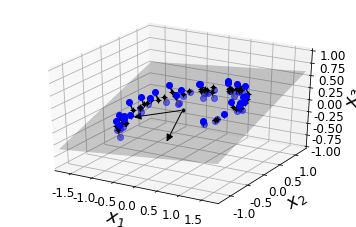

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


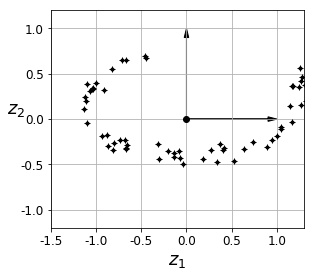

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

In [25]:
#스위스 롤
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


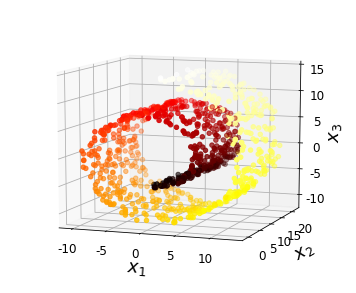

In [26]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


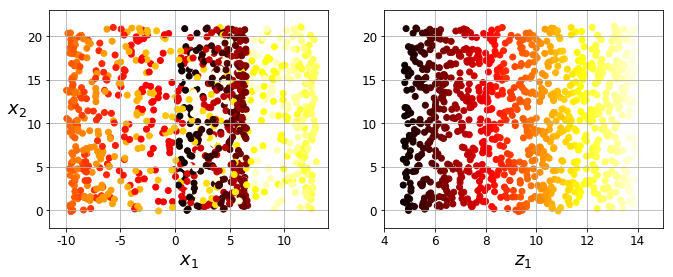

In [27]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


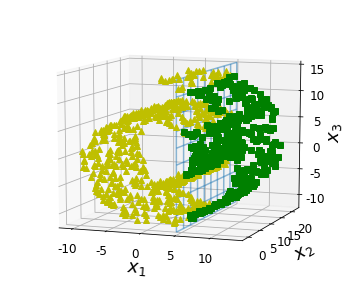

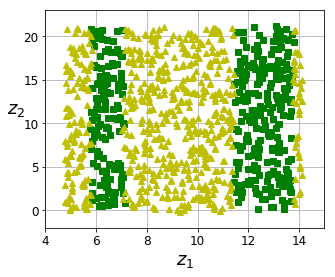

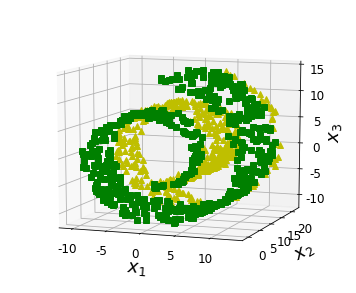

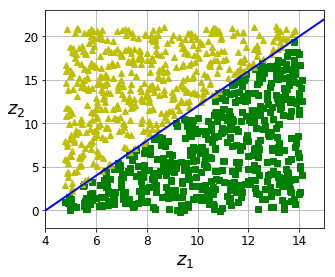

In [28]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


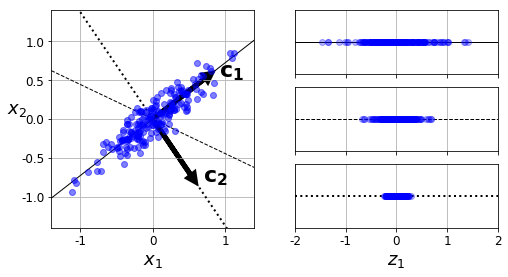

In [29]:
#PCA
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

In [30]:
#MNIST data set에 적용하기
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [31]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [32]:
#잃어버리는 분산의 비율이 5%이하가 되게 축소할 차원 설정하기
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [33]:
d

154

In [34]:
#해당 차원으로 축소시키기
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [35]:
pca.n_components_

154

In [36]:
np.sum(pca.explained_variance_ratio_)

0.9503623084769209

In [37]:
#축소된 차원 복원하기
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced) #5%의 손실 발생

In [38]:
#손실된 부분 눈으로 확인하기
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

Text(0.5,1,'original after compression')

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


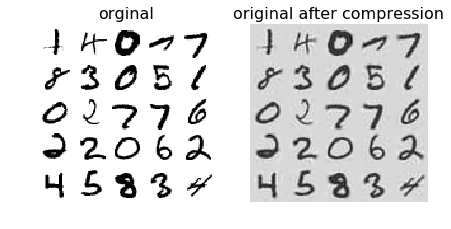

In [39]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("orginal", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("original after compression", fontsize=16)

In [40]:
X_reduced_pca = X_reduced

In [41]:
#IPCA(점진적 PCA)
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch) #partial_fit

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [42]:
#되돌리기
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


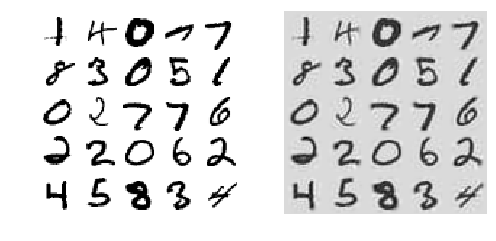

In [46]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [47]:
X_reduced_inc_pca = X_reduced

In [43]:
#PCA와 IPCA의 비교
np.allclose(pca.mean_, inc_pca.mean_)

True

In [48]:
#평균은 동일하지만 결과 자체는 동일하지 않음
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

In [49]:
#memmap() 사용하기
filename = "my_mnist.data"
m, n = X_train.shape #m = 사진의 갯수 n = 픽셀의 

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [53]:
del X_mm #개체를 삭제하여 python 종결자를 호출해서 데이터를 디스크에 저장한다.

In [54]:
#다른 프로그램에서 데이터를 로드하여 사용
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [57]:
#PCA, IPCA, Randomized PCA의 시간 소요
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 5.0 seconds
    IncrementalPCA: 39.7 seconds
    PCA: 4.5 seconds
n_components = 10
    PCA: 5.6 seconds
    IncrementalPCA: 41.5 seconds
    PCA: 5.4 seconds
n_components = 154
    PCA: 18.5 seconds
    IncrementalPCA: 84.8 seconds
    PCA: 20.5 seconds


Text(0.5,1,'time complexion of PCA & random PCA')

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


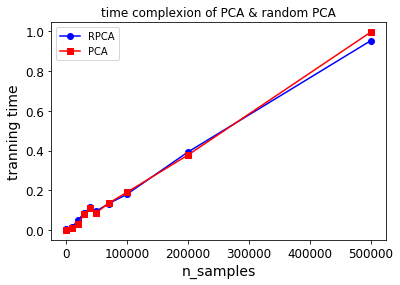

In [58]:
#데이터의 크기에 따른 비교
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("tranning time")
plt.legend(loc="upper left")
plt.title("time complexion of PCA & random PCA")

Text(0.5,1,'time complexion of PCA & randomized PCA')

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


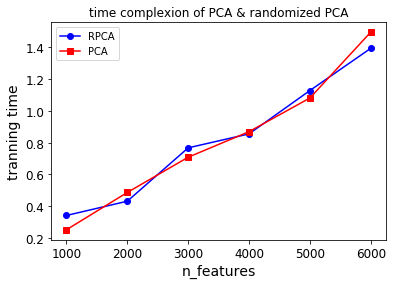

In [59]:
#특성의 개수를 달리하면서 2,000 샘플이 있는 데이터셋에서 성능을 비교
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("tranning time")
plt.legend(loc="upper left")
plt.title("time complexion of PCA & randomized PCA")

In [60]:
#커널 PCA
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [61]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


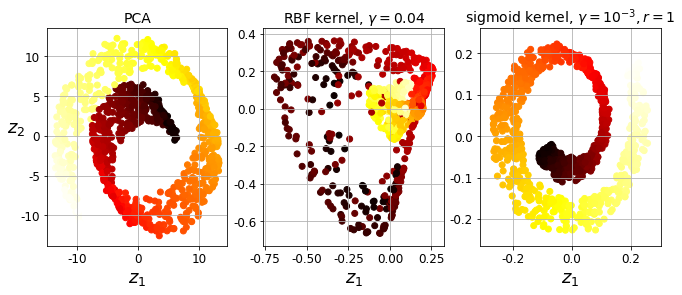

In [63]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) #일반적인 PCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "PCA"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [64]:
#Cross Validation을 통한 hyperparameter 튜닝
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [65]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [66]:
#재구성 원상을 이용한 huperparamter tunning
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [67]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage) #이 거리가 최소가 되게끔 하는 커널과 하이퍼파라미터 이용

32.786308795766125

In [68]:
#LLE를 이용한 차원축소
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [69]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


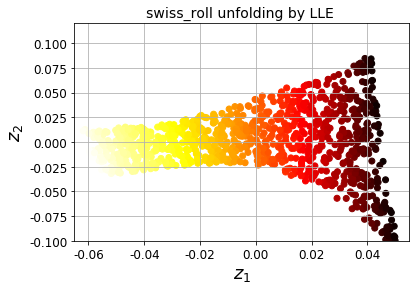

In [71]:
plt.title("swiss_roll unfolding by LLE ", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

In [72]:
#그 외의 차원 축소 기법(MDS, Isomap 그리고 t-SNE)
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [73]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [75]:
#LDA(원래는 분류 알고리즘)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


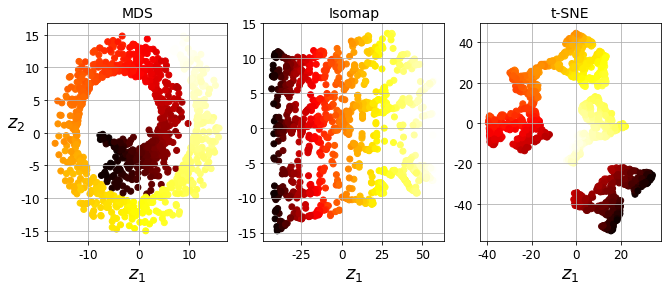

In [76]:
#그래프
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

In [77]:
#PCA의 성능 알아보기
#데이터 로드
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [78]:
#data set 나누기
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [79]:
#randomforest 적합
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [80]:
#시간 재기
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [81]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 8.11s


In [82]:
#정확도 측정
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455

In [83]:
#설명된 분산이 95%가 되도록 차원을 축소
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [84]:
#새로운 data set으로 randomforest 재적합시키고 시간 측정
rnd_clf2 = RandomForestClassifier(random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [85]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 17.47s


In [86]:
#정확도 평가
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8908

In [87]:
#LogisticRegression의 경우 살펴보기
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [88]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 57.12s


In [89]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [90]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [91]:
print("훈련 시간: {:.2f}s".format(t1 - t0)) #훈련시간이 확실히 줄어듦

훈련 시간: 20.22s


In [92]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

In [93]:
#T-SNE 사용하여 차원 축소해보기
#데이터 로드
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

In [94]:
#10000개의 데이터만 이용
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [95]:
#t-SNE를 이용한 차원 축소
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


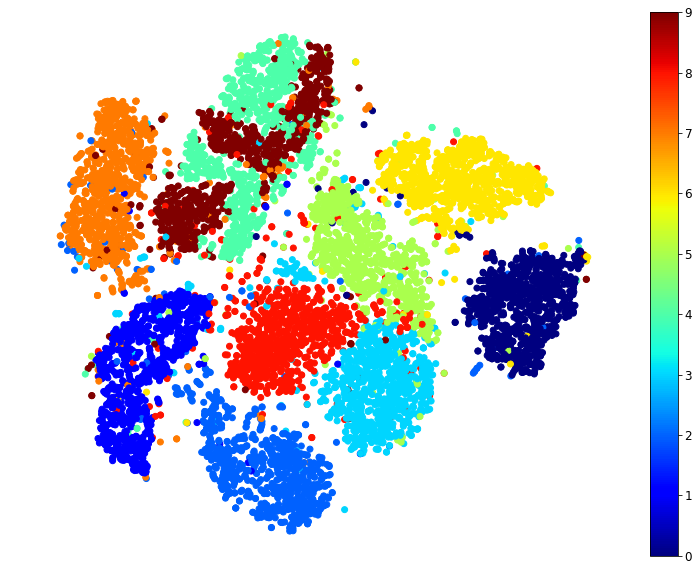

In [96]:
#시각화
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()
#이 그래프는 어떤 숫자가 다른 것과 구분이 쉬운지 알려 줍니다(가령, 0, 6 등이 잘 구분되어 있습니다). 
#그리고 어떤 숫자가 구분이 어려운지 알려 줍니다(가령, 4, 9입니다).

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


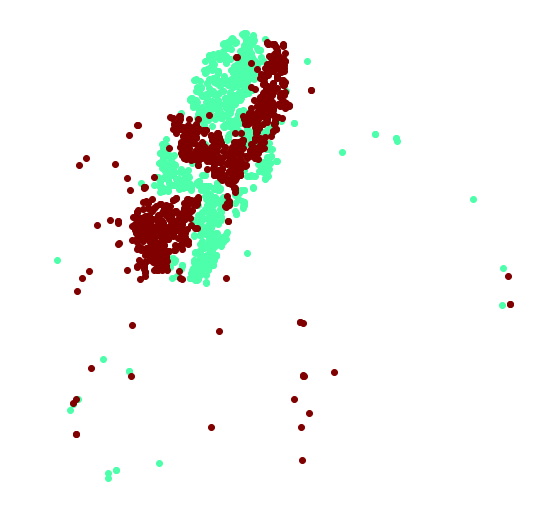

In [97]:
#4와9에 집중
plt.figure(figsize=(9,9))
cmap = matplotlib.cm.get_cmap("jet")
for digit in (4, 9):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

In [98]:
#4와9만 한번더 축소
idx = (y == 4) | (y == 9)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


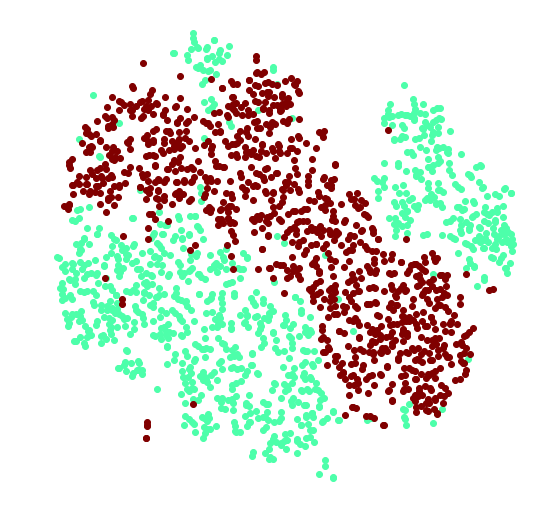

In [99]:
plt.figure(figsize=(9,9))
for digit in (4, 9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

In [100]:
#각 군집에 숫자 표기하기
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만듭니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만듭니다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽습니다.
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져옵니다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


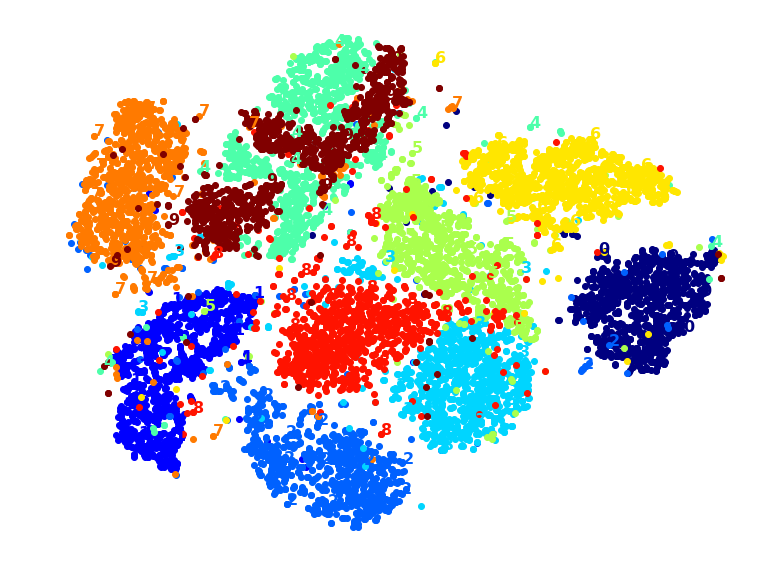

In [101]:
plot_digits(X_reduced, y)

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


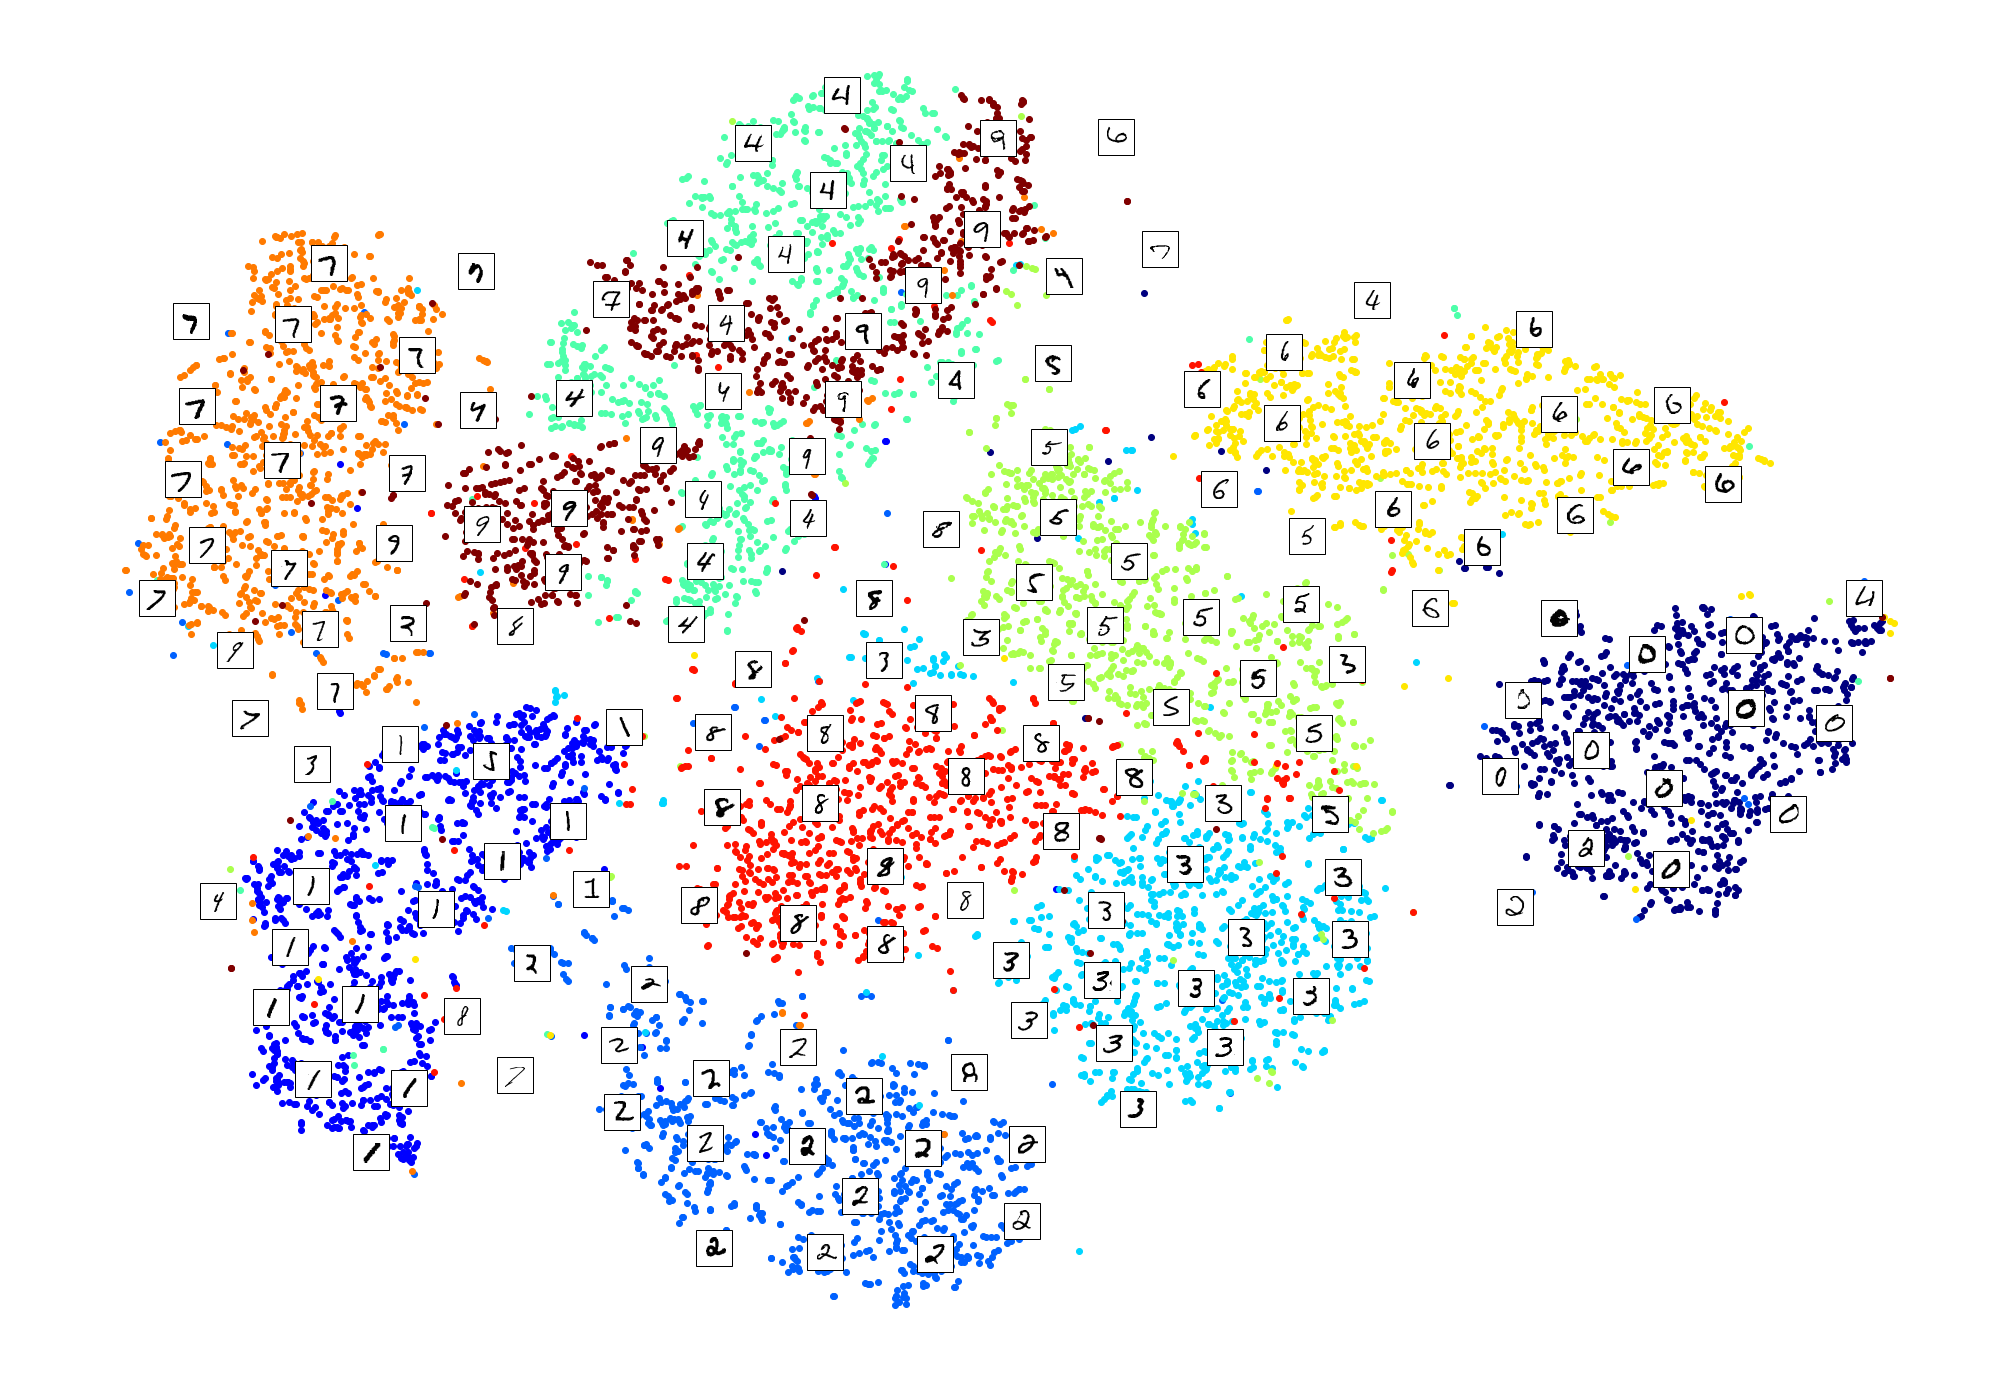

In [102]:
#숫자 이미지 사용
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


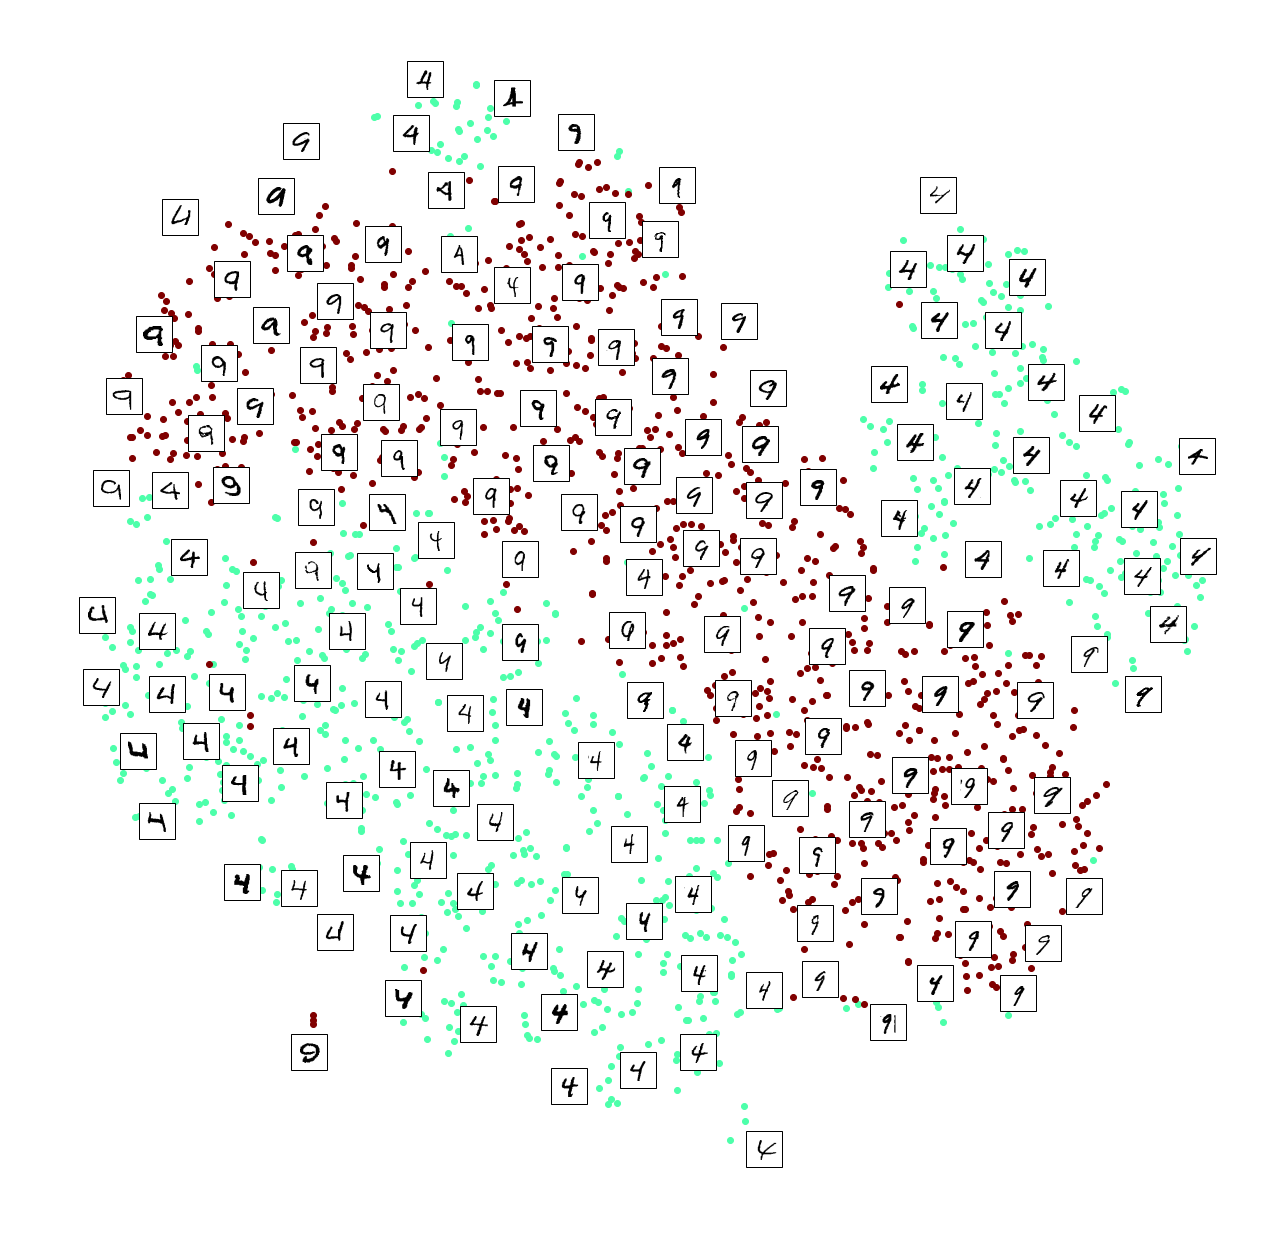

In [103]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

PCA 시간: 1.3s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


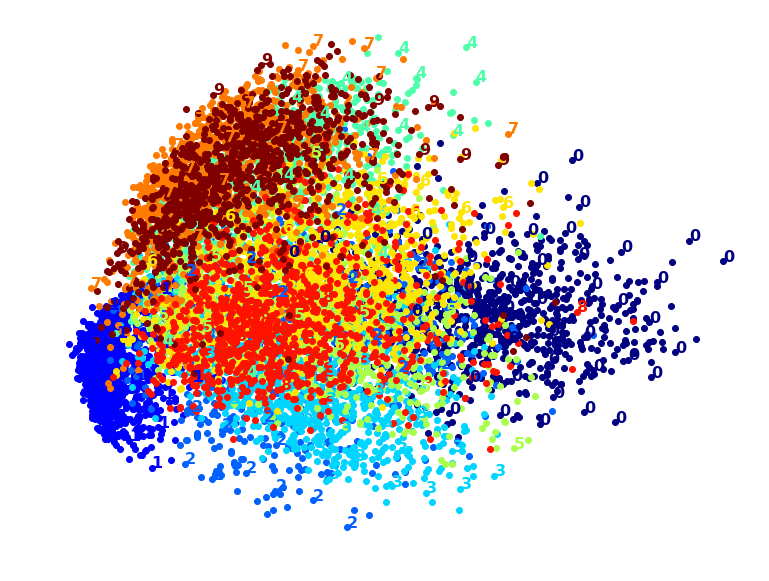

In [104]:
#PCA
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

LLE 시간: 256.9s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


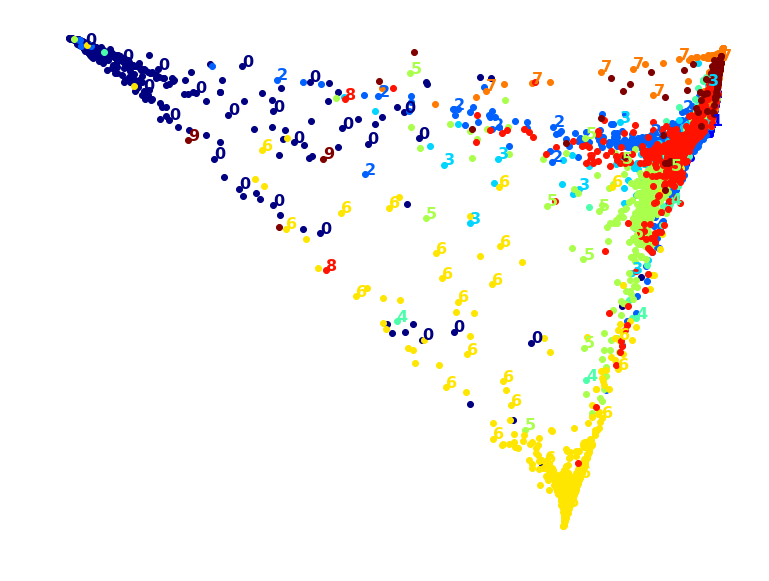

In [105]:
#LLE
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

PCA+LLE 시간: 91.8s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


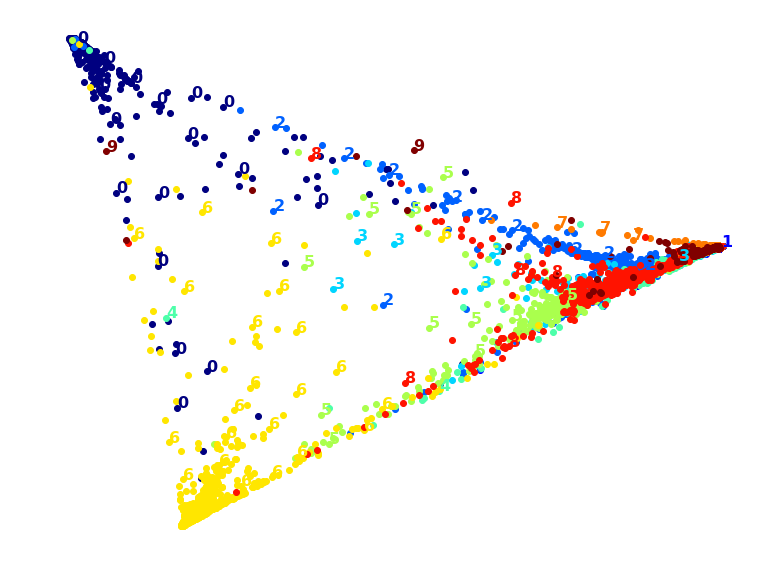

In [106]:
#95%보존 PCA
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

MDS 시간: 318.4s (10,000개가 아니고 2,000 MNIST 이미지에서).


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


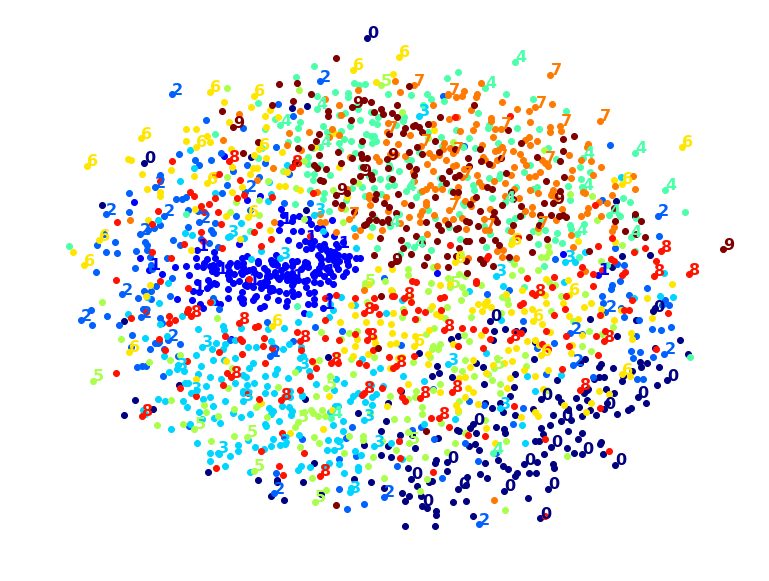

In [107]:
#MDS
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간: {:.1f}s (10,000개가 아니고 2,000 MNIST 이미지에서).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

PCA+MDS 시간: 305.8s (on 2,000 MNIST images).


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


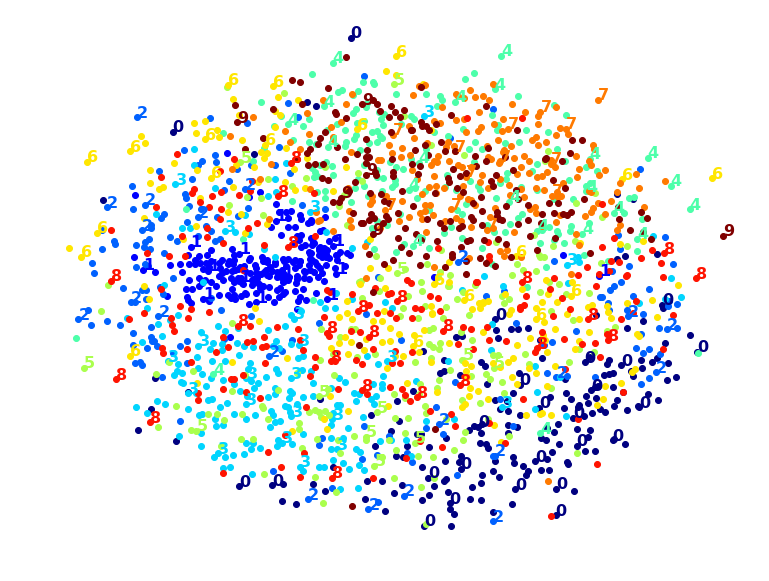

In [108]:
#PCA후에 MDS 적용하기
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간: {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

C:\Users\admin\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA 시간: 5.6s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


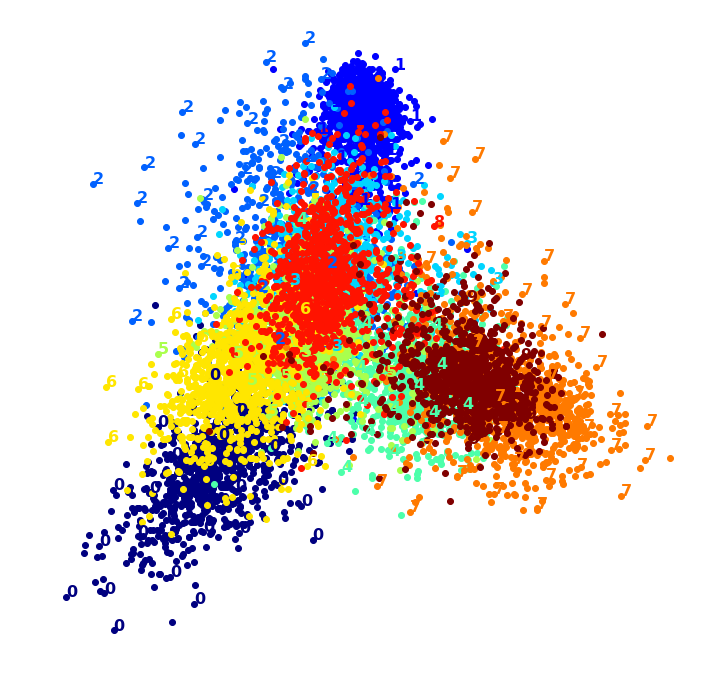

In [109]:
#LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

t-SNE 시간: 751.3s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


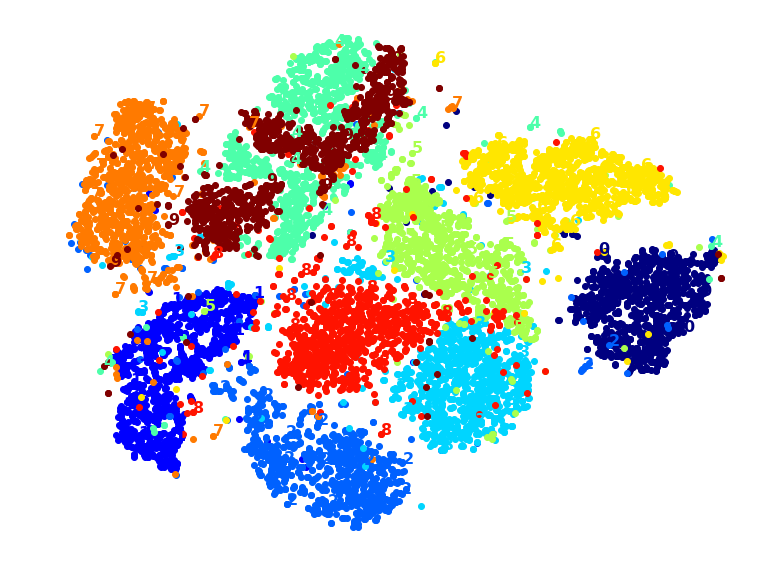

In [110]:
#TSNE 시간 재보기
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

PCA+t-SNE 시간 578.6s.


C:\Users\admin\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1328: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


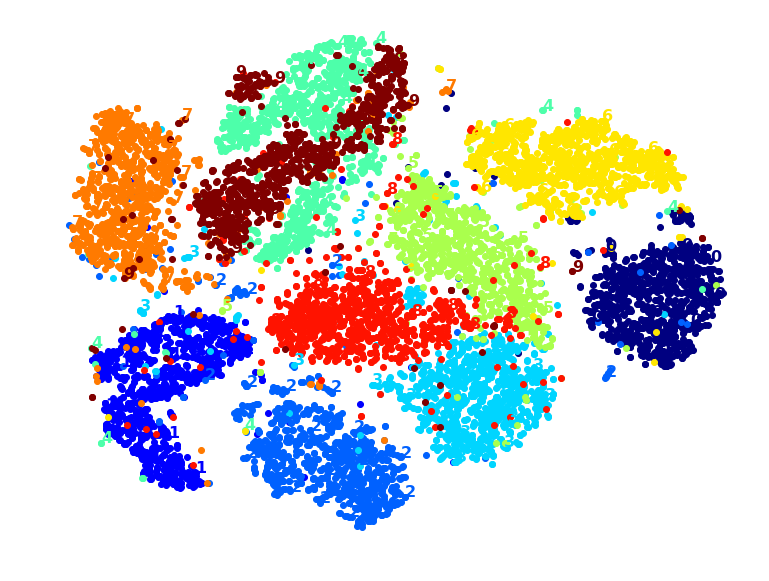

In [111]:
#PCA를 적용한 후 TSNE적용해보기
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()